In [97]:
include("./trajopt/utils.jl")
include("./trajopt/dynamics.jl")
include("./jointopt/joint_dynamics.jl")
include("./jointopt/joint_utils.jl")
include("./jointopt/joint_constraint.jl")
include("./trajopt/scaling.jl")

compute_scaling (generic function with 1 method)

In [98]:
# load nominal trajectory
using JLD2, FileIO
@load "./data/xuQYZ_unicycle_0328" my_dict
xnom = my_dict["x"]
unom = my_dict["u"]
tnom = my_dict["t"]
Qnom = my_dict["Q"]
Ynom = my_dict["Y"]
Znom = my_dict["Z"]
N = size(xnom,2) - 1
dtnom = zeros(N)
for i in 1:N
    dtnom[i] = tnom[i+1]-tnom[i]
end

In [99]:
ix = 3
iu = 2
iϕ = 2
iv = 2
iψ = iϕ*iv
iμ = iψ
@assert size(xnom,2) - 1 == N

In [100]:
dynamics = Unicycle()
alpha = 0.1
DLMI = LinearQY(alpha,ix,iu)

LinearQY(0.1, 3, 2, 9, 6, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1])

In [101]:
function get_H_obs(rx,ry)
    return diagm([1/rx,1/ry])
end
c_list = []
H_list = []
c1 = [1,2]
H1 = get_H_obs(0.5,0.5)
push!(c_list,c1)
push!(H_list,H1)
c2 = [4,3]
H2 = get_H_obs(0.5,0.5)
push!(c_list,c2)
push!(H_list,H2)

vmax = 2.0
vmin = 0.0
wmax = 2.0
wmin = -2.0
list_const = [InputConstraint([1;0],vmax),
    InputConstraint([-1;0],-vmin),
    InputConstraint([0; 1],wmax),
    InputConstraint([0; -1],-wmin),
    # ObstacleAvoidance(H_list[1],c_list[1]),
    # ObstacleAvoidance(H_list[2],c_list[2])
    ]

4-element Vector{InputConstraint}:
 InputConstraint([1, 0], 2.0)
 InputConstraint([-1, 0], -0.0)
 InputConstraint([0, 1], 2.0)
 InputConstraint([0, -1], 2.0)

In [102]:
xi = [0;0;0]
xf = [5;5;0]
Qini = diagm([0.08,0.08,0.06])
Qf = diagm([0.08,0.08,0.06])

3×3 Matrix{Float64}:
 0.08  0.0   0.0
 0.0   0.08  0.0
 0.0   0.0   0.06

In [103]:
x0 = zeros(ix,N+1);
u0 = 0.1*ones(iu,N+1);
for i = 1:N+1
    x0[:,i] = (N-i+1)/N*xi+(i-1)/N*xf;
end
Q0 = zeros(ix,ix,N+1)
Y0 = zeros(iu,ix,N+1)
Z0 = zeros(ix,ix,N+1);

In [104]:
xmin = [0;0;0];
xmax = [5;5;pi];
umin = [0;0];
umax = [vmax;wmax];
scaler = Scaling(xmin, xmax, umin, umax, tnom[end],0,0)

Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 3.0443980516e-314)

In [105]:
include("./jointopt/joint_synthesis.jl")

run (generic function with 1 method)

In [131]:
max_iter = 100;
w_traj = 1e-6;
w_funl = 1e-1;
w_vc_traj = 1e2;
w_vc_funl = 1e2;
w_tr_traj::Float64 = 1e1
w_tr_funl::Float64 = 1e-6
w_rate = 1e-3;
tol_vc = 1e-6;
tol_tr = 1e-4;
tol_dyn = 1e-1;
verbosity = true;

In [132]:
js = JointSynthesis(N,max_iter,
    dynamics,DLMI,list_const,scaler,
    w_traj,w_funl,
    w_vc_traj,w_vc_funl,
    w_tr_traj,w_tr_funl,
    w_rate,
    tol_tr,tol_vc,tol_dyn,verbosity)

JointSynthesis(Unicycle(3, 2, 2, 2, 2, 2, [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [1.0 0.0; 0.0 1.0; 0.0 0.0], [0.0 0.0 1.0; 0.0 0.0 0.0], [0.0 0.0; 1.0 0.0], [0.0, 0.0]), LinearQY(0.1, 3, 2, 9, 6, [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1], [1 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 0 … 0 1]), JointConstraint[InputConstraint([1, 0], 2.0), InputConstraint([-1, 0], -0.0), InputConstraint([0, 1], 2.0), InputConstraint([0, -1], 2.0)], Scaling([5.0 0.0 0.0; 0.0 5.0 0.0; 0.0 0.0 3.141592653589793], [0.2 0.0 0.0; 0.0 0.2 0.0; 0.0 0.0 0.3183098861837907], [0.0, 0.0, 0.0], [2.0 0.0; 0.0 2.0], [0.5 0.0; 0.0 0.5], [0.0, 0.0], 5.0, 0.0, 0.0, 3.0443980516e-314), JointSolution([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.0 0.0;;; 0.0 0.0 0.0; 0.0 0.0 0.0; 0.0 0.

In [133]:
run(js,x0,u0,dtnom,Q0,Y0,Z0,xi,xf,Qini,Qf,"Mosek")
# run(js,xnom,unom,dtnom,Qnom,Ynom,Znom,xi,xf,Qini,Qf,"Mosek")

+------------------------------------------------------------------------------------------------------------------------+
|                                                 ..:: Joint Synthesis ::..                                              |
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+----------+----------+
| iter. |    cost    |    traj   |   funl    |   rate    |log(vc_t)|log(vc_f)|log(tr_t) |log(tr_f) |log(dyn_t)|log(dyn_f)|
+-------+------------+-----------+-----------+-----------+---------+---------+----------+----------+----------+----------+
|1      |139.12      |20.258    |-3.845     |0.093      |-0.0     |-1.9     |0.6      |2.0      | -6.0e-01    |1.0e+00   |
|2      |66.88       |24.153    |-4.098     |0.161      |-0.2     |-5.8     |-0.3     |1.9      | -6.3e-01    |4.2e-01   |
|3      |19.42       |46.277    |-6.906     |0.371      |-7.3     |-6.0     |0.3      |1.0      | -9.8e-01    |3.8e-01   |
|4      |0.97   

In [134]:
tprop,xprop,uprop = js.solution.tprop,js.solution.xprop,js.solution.uprop
Qprop,Yprop = js.solution.Qprop,js.solution.Yprop

([224.5280293510842 -209.502476138936 69.43386345298607; -209.502476138936 210.20111798928644 -70.92865507485533; 69.43386345298607 -70.92865507485533 28.829288568606795;;; 224.71859102134763 -209.0202854935394 69.52514688404524; -209.0202854935394 208.95528989088595 -70.71566661377422; 69.52514688404524 -70.71566661377422 28.81437008175505;;; 225.1176849253568 -207.8001423917241 69.72740020509583; -207.8001423917241 205.92710885170627 -70.19048975927129; 69.72740020509583 -70.19048975927129 28.780043573625985;;; … ;;; 0.11616195774939453 0.014395436261878333 0.0017937470968186309; 0.014395436261921043 0.08142254649954828 -0.013467006352679577; 0.0017937470968191378 -0.013467006352701504 0.10327842438139558;;; 0.09371505417746608 0.005544883410461752 0.0007131565743196126; 0.005544883410504985 0.08004908483029702 -0.004716207110398316; 0.0007131565743204778 -0.004716207110423635 0.07652025169624799;;; 0.07999990136591972 6.759186871599556e-8 2.812425702839205e-8; 6.759190959657879e-8 0

In [135]:
function get_radius_angle_Ellipse2D(Q_list)
    radius_list = []
    angle_list = []

    for i in 1:size(Q_list,3)
        Q_ = Q_list[:,:,i]
        eigval = eigvals(inv(Q_))
        radius = sqrt.(1 ./ eigval)
        # println("radius of x,y,theta: ", radius)
        A = [1 0 0; 0 1 0]
        Q_proj = A * Q_ * A'
        Q_inv = inv(Q_proj)
        eigval, eigvec = eigen(Q_inv)
        radius = sqrt.(1 ./ eigval)
        # println("radius of x and y: ", radius)
        rnew = eigvec * [radius[1]; 0]
        angle = atan(rnew[2], rnew[1])
        push!(radius_list, radius)
        push!(angle_list, angle)
    end
    return radius_list, angle_list
end

get_radius_angle_Ellipse2D (generic function with 1 method)

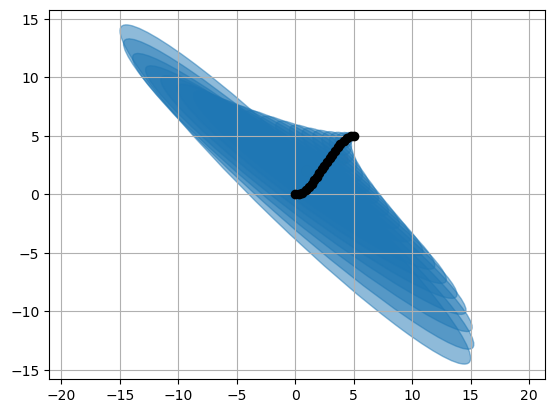

In [136]:
radius_Q,angle_Q = get_radius_angle_Ellipse2D(js.solution.Q)
radius_Qi,angle_Qi = get_radius_angle_Ellipse2D(js.solution.Qi)
radius_Qf,angle_Qf = get_radius_angle_Ellipse2D(js.solution.Qf)

plt.figure()
ax = plt.subplot(111)
for (ce, H) in zip(c_list, H_list)
    rx = 1 / H[1, 1]  # Adjusted indexing for Julia (1-based indexing)
    ry = 1 / H[2, 2]  # Adjusted indexing for Julia
    circle1 = matplotlib[:patches][:Ellipse]((ce[1], ce[2]), width=rx*2, height=ry*2, color="tab:red", alpha=0.5, fill=true)
    ax[:add_patch](circle1)  # Using add_patch method to add the ellipse to the plot
end
for i in 1:N+1
    x_ = js.solution.x[:,i]
    radius = radius_Q[i]
    angle = angle_Q[i]
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:blue",alpha=0.5,fill=true)
    ax.add_patch(ell)
end
for (x_,radius,angle) in zip([js.solution.x[:,1],js.solution.x[:,end]],[radius_Qi[1],radius_Qf[1]],[angle_Qi[1],angle_Qf[1]])
    ell = matplotlib[:patches][:Ellipse]((x_[1],x_[2]),radius[1]*2,radius[2]*2,angle=rad2deg(angle),color="tab:green",alpha=0.5,fill=true)
    ax.add_patch(ell)
end

ax.plot(js.solution.x[1,:],js.solution.x[2,:],"o-",color="black")
ax.grid(true)
ax[:axis]("equal")
gcf()

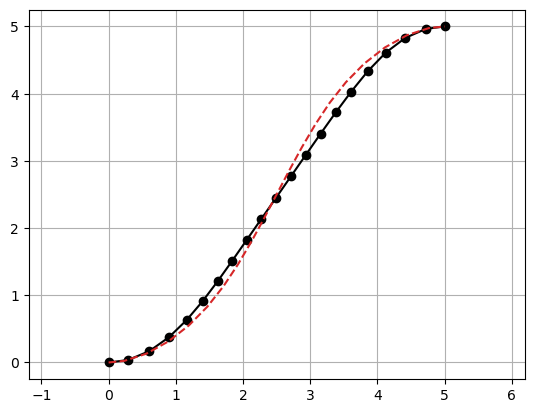

In [137]:
plt.figure()
ax = plt.subplot(111)
ax.plot(js.solution.x[1,:],js.solution.x[2,:],"o-",color="black")
ax.plot(xnom[1,:],xnom[2,:],"--",color="tab:red")
ax.grid(true)
ax[:axis]("equal")
gcf()

## Check eigenvalue of Q

In [138]:
min_lam_q = zeros(size(Qprop,3))
for i in 1:size(Qprop,3)
    eigvals = eigen(Qprop[:,:,i]).values
    min_lam_q[i] = eigvals[1]
end

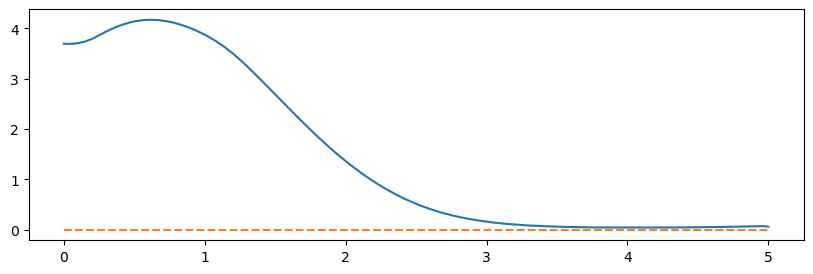

In [139]:
plt.figure(figsize=(10,3))
plt.plot(tprop,min_lam_q)
plt.plot(tprop,tprop*0,"--")
gcf()

In [140]:
findfirst(x -> x < 0, min_lam_q)

In [141]:
min_lam_q[85]

0.14679825384431552

In [142]:
function project_onto_input(Q,Y) 
    R = []
    for i in 1:size(Q,3)
        K = Y[:,:,i] * inv(Q[:,:,i])
        push!(R,K*Q[:,:,i]*K')
    end
    projected_input_funl = []
    for j in 1:iu
        a = zeros(iu)
        a[j] = 1
        each_funl = []
        for i in 1:length(R)
            push!(each_funl,sqrt(a'*R[i]*a))
        end
        push!(projected_input_funl,each_funl)
    end
    return projected_input_funl
end

project_onto_input (generic function with 1 method)

In [143]:
input_proj_funl_nom = project_onto_input(js.solution.Q,js.solution.Y)
input_proj_funl_prop = project_onto_input(Qprop,Yprop)

2-element Vector{Any}:
 Any[0.9875111952421859, 0.9762482815905974, 0.9488352980470405, 0.9119790298434802, 0.8655212625666318, 0.8080723026354325, 0.7392665138018439, 0.6611294175924048, 0.661129410436089, 0.6578690337146401  …  0.7463541015875673, 0.7463540065875973, 0.7531032949521489, 0.7671900545140621, 0.7859439555829548, 0.8112184453639596, 0.844200592219425, 0.8882127018417515, 0.9494612365192642, 0.9999976124950937]
 Any[1.1567370490802473, 1.1441160715864458, 1.1134305154655568, 1.072364734474989, 1.0211389591977311, 0.9589464043921346, 0.8864993305322996, 0.807204573713947, 0.8072045752093584, 0.8192283776503374  …  0.7621617532058858, 0.7621617302689365, 0.768445163772018, 0.7820393793477376, 0.8011550468348216, 0.8288279997406659, 0.868463813103841, 0.92812044585373, 1.025424926533738, 1.1199642657278932]

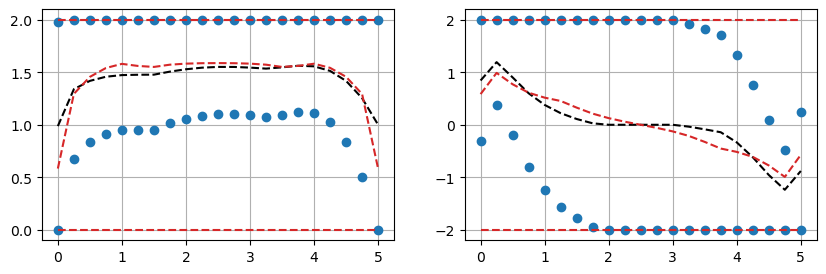

In [144]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.plot(tnom,js.solution.u[1,:],"--",color="black")
plt.plot(tnom,unom[1,:],"--",color="tab:red")
plt.plot(tnom,js.solution.u[1,:]+input_proj_funl_nom[1],"o",color="tab:blue")
plt.plot(tnom,js.solution.u[1,:]-input_proj_funl_nom[1],"o",color="tab:blue")
# plt.plot(tprop,uprop[1,:]+input_proj_funl_prop[1],"-",color="tab:blue")
# plt.plot(tprop,uprop[1,:]-input_proj_funl_prop[1],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ vmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ vmin,"--",color="tab:red")
# plt.ylim([-0.1,2.1])
plt.grid(true)
plt.subplot(122)
plt.plot(tnom,js.solution.u[2,:],"--",color="black")
plt.plot(tnom,unom[2,:],"--",color="tab:red")
plt.plot(tnom,js.solution.u[2,:]+input_proj_funl_nom[2],"o",color="tab:blue")
plt.plot(tnom,js.solution.u[2,:]-input_proj_funl_nom[2],"o",color="tab:blue")
# plt.plot(tprop,uprop[2,:]+input_proj_funl_prop[2],"-",color="tab:blue")
# plt.plot(tprop,uprop[2,:]-input_proj_funl_prop[2],"-",color="tab:blue")
plt.plot(tnom,tnom*0 .+ wmax,"--",color="tab:red")
plt.plot(tnom,tnom*0 .+ wmin,"--",color="tab:red")
# plt.ylim([-2.5,2.5])
plt.grid(true)
gcf()